In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import neuralop
from matplotlib import pyplot as plt
import numpy as np
from utils import FourierPoly2D
from functools import partial
import scipy.interpolate as interpolate
import hydra
from hydra.utils import to_absolute_path
from nv_utils import HDF5MapStyleDataset
%matplotlib inline

In [2]:
torch.manual_seed(0)

In [3]:
device = 'cuda:1'

In [4]:
dataset = HDF5MapStyleDataset(
    to_absolute_path("/srv/fast1/n.lokshin/Darcy_241/train.hdf5"), device='cpu'
)

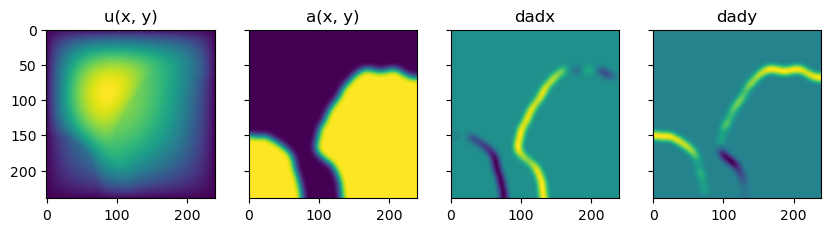

In [5]:
invar, outvar, x_invar, y_invar = dataset[1]
a = invar[0]
dadx = invar[1]
dady = invar[2]

fig, axs = plt.subplots(1, 4, figsize=(10, 10), sharey=True)
axs[0].imshow(outvar[0].cpu().numpy())
axs[0].set_title("u(x, y)")
axs[1].imshow(a.cpu().numpy())
axs[1].set_title("a(x, y)")
axs[2].imshow(dadx.cpu().numpy())
axs[2].set_title("dadx")
axs[3].imshow(dady.cpu().numpy())
axs[3].set_title("dady")
plt.show()

In [6]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()

        CH = 128

        self.branch = nn.Sequential(
            nn.Conv2d(3, CH, 3, 1, 1),
            nn.BatchNorm2d(CH),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 3, 1, 1),
            nn.BatchNorm2d(CH),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 3, 1, 1),
            nn.BatchNorm2d(CH),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 3, 1, 1),
            #nn.AdaptiveAvgPool2d((1, 1))
        )
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, CH, 1),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 1),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 1),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 1),
            nn.Tanh(),
            nn.Conv2d(CH, CH, 1)
        )
        self.branch2 = torch.hub.load(
            'mateuszbuda/brain-segmentation-pytorch',
            'unet',
            in_channels=3,
            out_channels=CH,
            init_features=32,
            pretrained=False
        )
        self.trunk1 = torch.hub.load(
            'mateuszbuda/brain-segmentation-pytorch',
            'unet',
            in_channels=2,
            out_channels=CH,
            init_features=32,
            pretrained=False
        )
        self.trunk = nn.Sequential(
            nn.Conv2d(2, CH, 1),
            nn.SiLU(),
            nn.Conv2d(CH, CH, 1),
            nn.SiLU(),
            nn.Conv2d(CH, CH, 1),
            nn.SiLU(),
            nn.Conv2d(CH, CH, 1),
            nn.SiLU(),
            nn.Conv2d(CH, CH, 1)
        )
        self.a1 = nn.SiLU()
        self.w1 = nn.Conv2d(CH, CH, 1)
        self.a2 = nn.SiLU()
        self.w2 = nn.Conv2d(CH, 1, 1)
        self.a3 = nn.SiLU()

    def forward(self, a, x, y):
        """
        a - batch_size x 1 x H x W
        x - batch_size x 1 x H x W
        y - batch_size x 1 x H x W
        """
        #u = self.trunk(x)
        #u = self.branch(a).squeeze(dim=(2, 3)) * self.trunk(torch.cat((x, y), dim=1))
        #u = self.trunk(torch.cat((x, y), dim=1))
        u = self.branch2(a) * self.trunk(torch.cat((x, y), dim=1))
        #u = self.a1(u)
        u = self.w1(u)
        u = self.a2(u)
        u = self.w2(u)
        #u = u**2
        u = self.a3(u)
        return u

In [7]:
def darcy_eq(model, a_full, dadx, dady, x, y):
    """
    model - the neural network
    a(x) - batch_size x 1 x H x W - diffusion coefficient at (x, y)
    dadx = batch_size x 1 x H x W - partial derivative of diffusion coefficient at (x, y)
    dady = batch_size x 1 x H x W - partial derivative of diffusion coefficient at (x, y)
    x - batch_size x 1 x H x W - coordinate in [0, 1]
    y - batch_size x 1 x H x W - coordinate in [0, 1]
    """
    u = model(torch.cat((a_full, dadx, dady), dim=1), x, y)
    u_x, = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)
    u_y, = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)

    u_x.requires_grad_()
    u_y.requires_grad_()

    # au_x = x * y * u_x
    # au_y = x * y * u_y
    
    u_xx, = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)
    u_yy, = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)

    u_xx.requires_grad_()
    u_yy.requires_grad_()

    #darcy = a * (u_xx + u_yy) + 1.0
    darcy = a_full * (u_xx + u_yy) + dadx * u_x + dady * u_y + 1.0 #(1.0 * 4.49996e00 * 3.88433e-03)
    #darcy = F.pad(darcy[:, :, 2:-2, 2:-2], [2, 2, 2, 2], "constant", 0)
    return u, darcy
    #return u_xx + u_yy + 1.0


def bc(x):
    return 0.0

In [17]:
unet = DeepONet()
unet.to(device)
optim = torch.optim.Adam(unet.parameters(), lr=1e-4, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', factor=0.1, patience=10)
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=32
)
ITERS = 30
bc_loss_fn = torch.nn.L1Loss(reduction='sum') # torch.nn.MSELoss()
pde_loss_fn = torch.nn.L1Loss(reduction='mean') # torch.nn.L1Loss()
data_loss_fn = torch.nn.MSELoss(reduction='sum')

Using cache found in /home/n.lokshin/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/n.lokshin/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [18]:
for iter in range(ITERS):
    epoch_losses = []

    for batch in train_loader:
        invar, outvar, x, y = batch
        x.requires_grad_()
        y.requires_grad_()

        invar, outvar = invar.to(device), outvar.to(device)

        a_full, dadx_full, dady_full = invar[:, 0:1, ...], invar[:, 1:2, ...], invar[:, 2:3, ...]

        x, y = x.to(device), y.to(device)

        def closure():
            optim.zero_grad()
            bc_loss = torch.abs(unet(invar, x, torch.zeros_like(y)) - bc(x)) +\
                torch.abs(unet(invar, x, torch.ones_like(y)) - bc(x)) + \
                torch.abs(unet(invar, torch.zeros_like(x), y) - bc(x)) + \
                torch.abs(unet(invar, torch.ones_like(x), y) - bc(x))
            bc_loss = bc_loss.mean()

            u, darcy_loss = darcy_eq(unet, a_full, dadx_full, dady_full, x, y)
            pde_loss = pde_loss_fn(darcy_loss, torch.zeros_like(darcy_loss))
            data_loss = data_loss_fn(u, outvar)

            loss = 1e1 * bc_loss + pde_loss + 0.1 * data_loss
            #loss = loss.mean(dim=(1, 2, 3)).sum(0)
            loss.backward()
            return loss

        loss = optim.step(closure)
        epoch_losses.append(loss.item())

    iter_num = iter + 1
    scheduler.step(np.mean(epoch_losses))
    if iter_num % 10 == 0:
        print(f"[{iter_num}/{ITERS}] train_loss_median: {np.median(epoch_losses)} | train_loss_mean: {np.mean(epoch_losses)}")

[10/30] train_loss_median: 1.184787631034851 | train_loss_mean: 1.1878755688667297
[20/30] train_loss_median: 0.4931396096944809 | train_loss_mean: 0.49819681965387785
[30/30] train_loss_median: 0.3492753356695175 | train_loss_mean: 0.34787881488983446


tensor(3.0000) tensor(12.0000)
torch.Size([32, 32]) torch.Size([32, 32])


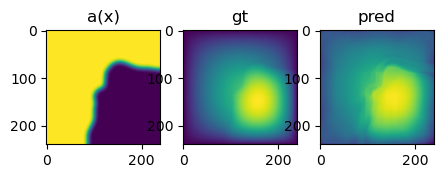

In [19]:
invar, outvar, x_invar, y_invar = dataset[12]
a = invar[0]# + (7.48360e00 / 4.49996e00)
print(a.min(), a.max())
dadx = invar[1]
dady = invar[2]

N = 32
with torch.no_grad():
    x = torch.linspace(0.0, 1.0, N).to(device)
    y = torch.linspace(0.0, 1.0, N).to(device)
    xg, yg = torch.meshgrid(x, y)
    print(xg.shape, yg.shape)
    pred = unet(invar[None].to(device), x_invar[None].to(device), y_invar[None].to(device))[0, 0]

#pred = np.reshape(pred.numpy(), (240, 240))

fig, axs = plt.subplots(1, 3, figsize=(5, 5))
axs[0].imshow(a.cpu().numpy())
axs[0].set_title("a(x)")
axs[1].imshow(outvar[0].cpu().numpy())
axs[1].set_title("gt")
axs[2].imshow(pred.cpu().numpy())
axs[2].set_title("pred")
plt.savefig("bc1e3_no_swicth.png")
plt.show()